# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [145]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
cases = 100
alpha = 10 ** (-2. * np.random.rand(cases) - 7.)
lambd = 10 ** (2. * np.random.rand(cases) + 4.7)
for i in range(cases):
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=alpha[i], reg=lambd[i],
             num_iters=1500, verbose=True)        
    y_train_pred = svm.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(alpha[i], lambd[i])] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 124.737886
iteration 100 / 1500: loss 121.703676
iteration 200 / 1500: loss 118.739678
iteration 300 / 1500: loss 115.851438
iteration 400 / 1500: loss 113.039292
iteration 500 / 1500: loss 110.311158
iteration 600 / 1500: loss 107.656140
iteration 700 / 1500: loss 105.063429
iteration 800 / 1500: loss 102.536967
iteration 900 / 1500: loss 100.091530
iteration 1000 / 1500: loss 97.692489
iteration 1100 / 1500: loss 95.370379
iteration 1200 / 1500: loss 93.092971
iteration 1300 / 1500: loss 90.881262
iteration 1400 / 1500: loss 88.734160
iteration 0 / 1500: loss 108.495812
iteration 100 / 1500: loss 92.561784
iteration 200 / 1500: loss 79.177713
iteration 300 / 1500: loss 67.942505
iteration 400 / 1500: loss 58.489654
iteration 500 / 1500: loss 50.559670
iteration 600 / 1500: loss 43.910121
iteration 700 / 1500: loss 38.312105
iteration 800 / 1500: loss 33.615394
iteration 900 / 1500: loss 29.673514
iteration 1000 / 1500: loss 26.362728
iteration 1100 / 1500: lo

iteration 0 / 1500: loss 191.670595
iteration 100 / 1500: loss 18.589277
iteration 200 / 1500: loss 9.502321
iteration 300 / 1500: loss 9.026252
iteration 400 / 1500: loss 9.001198
iteration 500 / 1500: loss 8.999896
iteration 600 / 1500: loss 8.999798
iteration 700 / 1500: loss 8.999793
iteration 800 / 1500: loss 8.999808
iteration 900 / 1500: loss 8.999822
iteration 1000 / 1500: loss 8.999836
iteration 1100 / 1500: loss 8.999804
iteration 1200 / 1500: loss 8.999806
iteration 1300 / 1500: loss 8.999789
iteration 1400 / 1500: loss 8.999830
iteration 0 / 1500: loss 784.235846
iteration 100 / 1500: loss 186.820649
iteration 200 / 1500: loss 49.785360
iteration 300 / 1500: loss 18.356688
iteration 400 / 1500: loss 11.145657
iteration 500 / 1500: loss 9.492183
iteration 600 / 1500: loss 9.112911
iteration 700 / 1500: loss 9.025826
iteration 800 / 1500: loss 9.005882
iteration 900 / 1500: loss 9.001303
iteration 1000 / 1500: loss 9.000282
iteration 1100 / 1500: loss 9.000032
iteration 1200 

iteration 0 / 1500: loss 1334.101783
iteration 100 / 1500: loss 18.236388
iteration 200 / 1500: loss 9.064341
iteration 300 / 1500: loss 9.000410
iteration 400 / 1500: loss 8.999980
iteration 500 / 1500: loss 8.999978
iteration 600 / 1500: loss 8.999972
iteration 700 / 1500: loss 8.999973
iteration 800 / 1500: loss 8.999971
iteration 900 / 1500: loss 8.999976
iteration 1000 / 1500: loss 8.999974
iteration 1100 / 1500: loss 8.999978
iteration 1200 / 1500: loss 8.999974
iteration 1300 / 1500: loss 8.999974
iteration 1400 / 1500: loss 8.999974
iteration 0 / 1500: loss 7822.513897
iteration 100 / 1500: loss 8.999996
iteration 200 / 1500: loss 8.999995
iteration 300 / 1500: loss 8.999995
iteration 400 / 1500: loss 8.999996
iteration 500 / 1500: loss 8.999996
iteration 600 / 1500: loss 8.999996
iteration 700 / 1500: loss 8.999996
iteration 800 / 1500: loss 8.999995
iteration 900 / 1500: loss 8.999996
iteration 1000 / 1500: loss 8.999996
iteration 1100 / 1500: loss 8.999995
iteration 1200 / 1

iteration 0 / 1500: loss 361.690327
iteration 100 / 1500: loss 241.434209
iteration 200 / 1500: loss 162.171265
iteration 300 / 1500: loss 109.947165
iteration 400 / 1500: loss 75.527521
iteration 500 / 1500: loss 52.846673
iteration 600 / 1500: loss 37.893429
iteration 700 / 1500: loss 28.040397
iteration 800 / 1500: loss 21.547761
iteration 900 / 1500: loss 17.267350
iteration 1000 / 1500: loss 14.448934
iteration 1100 / 1500: loss 12.590798
iteration 1200 / 1500: loss 11.366362
iteration 1300 / 1500: loss 10.559999
iteration 1400 / 1500: loss 10.027311
iteration 0 / 1500: loss 1984.962235
iteration 100 / 1500: loss 266.539089
iteration 200 / 1500: loss 42.565095
iteration 300 / 1500: loss 13.375139
iteration 400 / 1500: loss 9.569934
iteration 500 / 1500: loss 9.074214
iteration 600 / 1500: loss 9.009676
iteration 700 / 1500: loss 9.001237
iteration 800 / 1500: loss 9.000141
iteration 900 / 1500: loss 9.000004
iteration 1000 / 1500: loss 8.999985
iteration 1100 / 1500: loss 8.999980

iteration 0 / 1500: loss 113.014564
iteration 100 / 1500: loss 110.219863
iteration 200 / 1500: loss 107.487488
iteration 300 / 1500: loss 104.850364
iteration 400 / 1500: loss 102.245848
iteration 500 / 1500: loss 99.744825
iteration 600 / 1500: loss 97.289007
iteration 700 / 1500: loss 94.891772
iteration 800 / 1500: loss 92.571097
iteration 900 / 1500: loss 90.330480
iteration 1000 / 1500: loss 88.134594
iteration 1100 / 1500: loss 85.996688
iteration 1200 / 1500: loss 83.910332
iteration 1300 / 1500: loss 81.883738
iteration 1400 / 1500: loss 79.930826
iteration 0 / 1500: loss 147.306215
iteration 100 / 1500: loss 134.500548
iteration 200 / 1500: loss 122.905752
iteration 300 / 1500: loss 112.375848
iteration 400 / 1500: loss 102.811473
iteration 500 / 1500: loss 94.145123
iteration 600 / 1500: loss 86.272076
iteration 700 / 1500: loss 79.119161
iteration 800 / 1500: loss 72.640746
iteration 900 / 1500: loss 66.750470
iteration 1000 / 1500: loss 61.406413
iteration 1100 / 1500: los

iteration 0 / 1500: loss 2229.553798
iteration 100 / 1500: loss 37.957009
iteration 200 / 1500: loss 9.377616
iteration 300 / 1500: loss 9.004916
iteration 400 / 1500: loss 9.000045
iteration 500 / 1500: loss 8.999980
iteration 600 / 1500: loss 8.999979
iteration 700 / 1500: loss 8.999986
iteration 800 / 1500: loss 8.999984
iteration 900 / 1500: loss 8.999983
iteration 1000 / 1500: loss 8.999985
iteration 1100 / 1500: loss 8.999984
iteration 1200 / 1500: loss 8.999983
iteration 1300 / 1500: loss 8.999985
iteration 1400 / 1500: loss 8.999984
iteration 0 / 1500: loss 738.662969
iteration 100 / 1500: loss 587.069850
iteration 200 / 1500: loss 466.977240
iteration 300 / 1500: loss 371.828571
iteration 400 / 1500: loss 296.449033
iteration 500 / 1500: loss 236.737514
iteration 600 / 1500: loss 189.414573
iteration 700 / 1500: loss 151.943761
iteration 800 / 1500: loss 122.242264
iteration 900 / 1500: loss 98.714150
iteration 1000 / 1500: loss 80.073589
iteration 1100 / 1500: loss 65.313133


iteration 0 / 1500: loss 1076.124419
iteration 100 / 1500: loss 63.516815
iteration 200 / 1500: loss 11.785462
iteration 300 / 1500: loss 9.142234
iteration 400 / 1500: loss 9.007249
iteration 500 / 1500: loss 9.000330
iteration 600 / 1500: loss 8.999981
iteration 700 / 1500: loss 8.999967
iteration 800 / 1500: loss 8.999969
iteration 900 / 1500: loss 8.999961
iteration 1000 / 1500: loss 8.999964
iteration 1100 / 1500: loss 8.999972
iteration 1200 / 1500: loss 8.999971
iteration 1300 / 1500: loss 8.999968
iteration 1400 / 1500: loss 8.999968
iteration 0 / 1500: loss 1722.263617
iteration 100 / 1500: loss 23.367885
iteration 200 / 1500: loss 9.120563
iteration 300 / 1500: loss 9.000985
iteration 400 / 1500: loss 8.999992
iteration 500 / 1500: loss 8.999980
iteration 600 / 1500: loss 8.999976
iteration 700 / 1500: loss 8.999972
iteration 800 / 1500: loss 8.999979
iteration 900 / 1500: loss 8.999984
iteration 1000 / 1500: loss 8.999979
iteration 1100 / 1500: loss 8.999979
iteration 1200 /

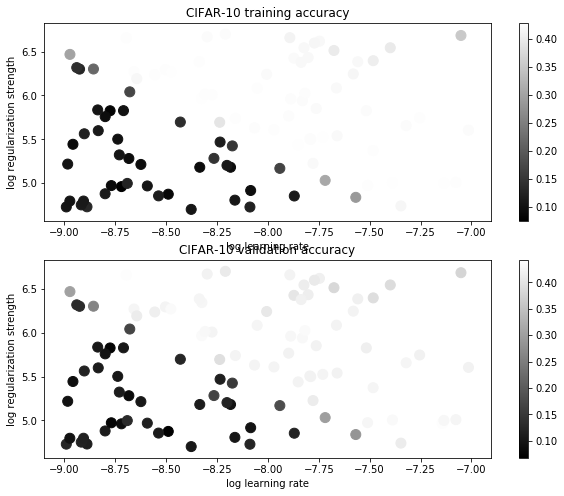

In [146]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [147]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


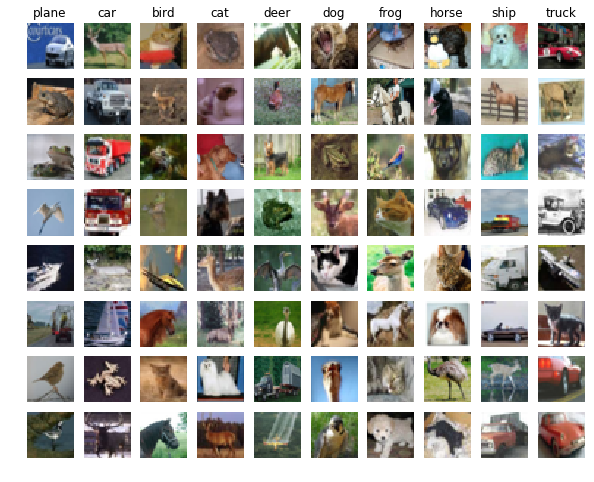

In [106]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [148]:
print(X_train_feats.shape)

(49000, 185)


In [13]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
cases = 30
alpha = 10 ** (-2 * np.random.rand(cases) - 0)
lambd = 10 ** (-5 * np.random.rand(cases) - 0)
batch_size = np.random.choice([200, 200, 200], cases)
num_iters = np.random.choice([1000, 1000, 1000, 1000, 1000, 1000], cases)

results = {}
best_val = -1
best_net = None

# Train the network
for i in range(cases):
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, init='he')
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=num_iters[i], batch_size=batch_size[i],
                      learning_rate=alpha[i], learning_rate_decay=0.95,
                      reg=lambd[i], verbose=True)
    
    results[(alpha[i], lambd[i], batch_size[i], num_iters[i])] = stats
    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print('Validation accuracy: ', val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_net = net

# Print out results.
for lr, reg, bs, ep in sorted(results):
    train_accuracy = results[(lr, reg, bs, ep)]['train_acc_history'][-1]
    val_accuracy = results[(lr, reg, bs, ep)]['val_acc_history'][-1]
    print('lr %e reg %e bs %d ep %d train accuracy: %f val accuracy: %f' % (
          lr, reg, bs, ep, train_accuracy, val_accuracy))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 8.094762
iteration 100 / 1000: loss 6.863235
iteration 200 / 1000: loss 6.636248
iteration 300 / 1000: loss 6.386008
iteration 400 / 1000: loss 6.251078
iteration 500 / 1000: loss 6.154339
iteration 600 / 1000: loss 5.903982
iteration 700 / 1000: loss 5.813091
iteration 800 / 1000: loss 5.761560
iteration 900 / 1000: loss 5.666826
Validation accuracy:  0.507
iteration 0 / 1000: loss 44.966853
iteration 100 / 1000: loss 14.099238
iteration 200 / 1000: loss 5.570242
iteration 300 / 1000: loss 3.017776
iteration 400 / 1000: loss 2.394080
iteration 500 / 1000: loss 2.107641
iteration 600 / 1000: loss 1.988628
iteration 700 / 1000: loss 1.955090
iteration 800 / 1000: loss 1.898534
iteration 900 / 1000: loss 1.894378
Validation accuracy:  0.463
iteration 0 / 1000: loss 3.080268
iteration 100 / 1000: loss 1.527429
iteration 200 / 1000: loss 1.667163
iteration 300 / 1000: loss 1.421556
iteration 400 / 1000: loss 1.196791
iteration 500 / 1000: loss 1.208942
iteration 60

iteration 300 / 1000: loss 1.359415
iteration 400 / 1000: loss 1.232379
iteration 500 / 1000: loss 1.263934
iteration 600 / 1000: loss 1.295600
iteration 700 / 1000: loss 1.226387
iteration 800 / 1000: loss 1.276461
iteration 900 / 1000: loss 1.253393
Validation accuracy:  0.527
iteration 0 / 1000: loss 3.324766
iteration 100 / 1000: loss 1.833844
iteration 200 / 1000: loss 1.752850
iteration 300 / 1000: loss 1.622486
iteration 400 / 1000: loss 1.448301
iteration 500 / 1000: loss 1.350517
iteration 600 / 1000: loss 1.365877
iteration 700 / 1000: loss 1.176462
iteration 800 / 1000: loss 1.251422
iteration 900 / 1000: loss 1.163534
Validation accuracy:  0.568
iteration 0 / 1000: loss 3.148996
iteration 100 / 1000: loss 1.881983
iteration 200 / 1000: loss 1.481808
iteration 300 / 1000: loss 1.420912
iteration 400 / 1000: loss 1.436684
iteration 500 / 1000: loss 1.254887
iteration 600 / 1000: loss 1.208936
iteration 700 / 1000: loss 1.247864
iteration 800 / 1000: loss 1.133454
iteration 90

In [14]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.57


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!